In [1]:
import fiona, utm, os, re
import datetime
import rasterio
import pandas as pd
import folium
from rasterio.mask import mask
from skimage.exposure import equalize_hist
# from sklearn.decomposition import PCA
from statsmodels.graphics.functional import hdrboxplot
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

PROJ: proj_create_from_database: Cannot find proj.db


In [3]:
fields = {}
field_names = ['1', '2', '3', '4']
for field_name in field_names:
    with fiona.open('Polygones_21-03-2021_19-19-52.geojson', 'r') as shapefile:
        fields[field_name] = [feature['geometry'] for feature in shapefile
                              if feature['properties']['description'] == field_name]
        
for field_name in field_names:
    for field in fields[field_name]:
        if field['type']=='Polygon':
            field['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in field['coordinates'][0]]]
        else:
            geoms = []
            for geom in field['coordinates']:
                geoms.append([[utm.from_latlon(i[1], i[0])[:2] for i in geom[0]]])
            field['coordinates'] = geoms

In [4]:
fields['1'][0]['coordinates']

[[(410198.98082395527, 6188979.012373987),
  (410078.62928633415, 6188944.762902186),
  (410117.30387054395, 6188800.119086319),
  (410246.6451463716, 6188835.529180971),
  (410198.98082395527, 6188979.012373987)]]

In [5]:
ndvis = {}
for field_name in field_names:
    ndvis[field_name] = {}

In [6]:
root = '/Users/o.zhukova/Downloads/sentinel2/'

for folder in tqdm(next(os.walk(root))[1]):
    date = re.findall('(\d+)T', folder)[-1]
    
    for granule in next(os.walk(root+folder+'/GRANULE'))[1]:
        if 'T37UDB' in granule:
            for image in next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]:
                if '_B04.jp2' in image and 'aux.xml' not in image:
                    band_04 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
                elif '_B08.jp2' in image and 'aux.xml' not in image:
                    band_08 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_08 = mask(band_08, fields[field_name], nodata=0, crop=True)
        

        field_04 = masked_04[0].astype('int16')
        field_08 = masked_08[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_08 = field_08[np.nonzero(field_08)]
        
        ndvi = (field_08-field_04)/(field_08+field_04)
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = (np.mean(ndvi), np.std(ndvi))
    
    band_04.close()
    band_08.close()


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.10it/s]


In [6]:
next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]

['T37UDB_20201018T083951_B01.jp2',
 'T37UDB_20201018T083951_B02.jp2',
 'T37UDB_20201018T083951_B03.jp2',
 'T37UDB_20201018T083951_B04.jp2',
 'T37UDB_20201018T083951_B05.jp2',
 'T37UDB_20201018T083951_B06.jp2',
 'T37UDB_20201018T083951_B07.jp2',
 'T37UDB_20201018T083951_B08.jp2',
 'T37UDB_20201018T083951_B09.jp2',
 'T37UDB_20201018T083951_B10.jp2',
 'T37UDB_20201018T083951_B11.jp2',
 'T37UDB_20201018T083951_B12.jp2',
 'T37UDB_20201018T083951_B8A.jp2',
 'T37UDB_20201018T083951_TCI.jp2']

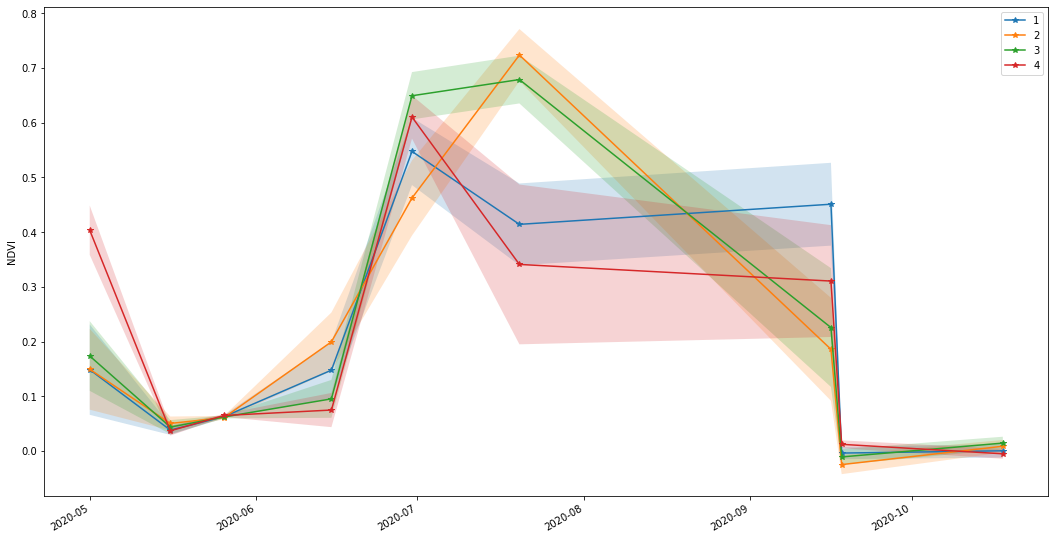

In [7]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date][0] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
    plt.fill_between(sorted(ndvis[field_name]), 
                 [ndvis[field_name][date][0]+ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                 [ndvis[field_name][date][0]-ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                     alpha=0.2)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [12]:
ndvis
ndvis['1'][datetime.date(2020, 10, 18)][0]

0.0004950484007954152

In [13]:
import itertools as IT


def scale_polygon(path,offset):
    center = centroid_of_polygon(path)
    for i in path:
        if i[0] > center[0]:
            i[0] += offset
        else:
            i[0] -= offset
        if i[1] > center[1]: 
            i[1] += offset
        else:
            i[1] -= offset
    return path


def area_of_polygon(x, y):
    """Calculates the signed area of an arbitrary polygon given its verticies
    http://stackoverflow.com/a/4682656/190597 (Joe Kington)
    http://softsurfer.com/Archive/algorithm_0101/algorithm_0101.htm#2D%20Polygons
    """
    area = 0.0
    for i in range(-1, len(x) - 1):
        area += x[i] * (y[i + 1] - y[i - 1])
    return area / 2.0


def centroid_of_polygon(points):
    """
    http://stackoverflow.com/a/14115494/190597 (mgamba)
    """
    area = area_of_polygon(*zip(*points))
    result_x = 0
    result_y = 0
    N = len(points)
    points = IT.cycle(points)
    x1, y1 = next(points)
    for i in range(N):
        x0, y0 = x1, y1
        x1, y1 = next(points)
        cross = (x0 * y1) - (x1 * y0)
        result_x += (x0 + x1) * cross
        result_y += (y0 + y1) * cross
    result_x /= (area * 6.0)
    result_y /= (area * 6.0)
    return (result_x, result_y)

In [14]:
field_number = '1'
with fiona.open('Polygones_21-03-2021_19-19-52.geojson', 'r') as shapefile:
    field = [feature['geometry'] for feature in shapefile if feature['properties']['description'] == field_number]
    
for entity in field:
    entity['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in entity['coordinates'][0]]]
    polygon = [[i[0], i[1]] for i in entity['coordinates'][0]]
    entity['coordinates'] = [scale_polygon(polygon, -30)]

In [16]:
ndvi_maps = [ndvi_maps[i] for i in np.argsort(dates)]
ndvi_values = [ndvi_values[i] for i in np.argsort(dates)]
dates = np.sort(dates)

Date: 2020-06-30


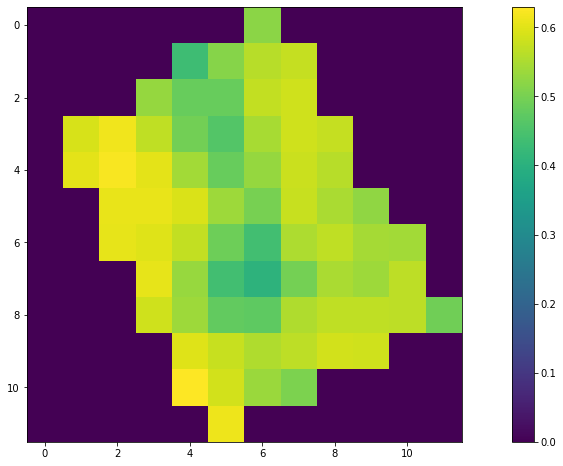

In [13]:
print('Date:', dates[4])

fig = plt.figure(figsize=(18,8))

plt.imshow(ndvi_maps[4]['image'])
plt.colorbar()

In [19]:
from folium.raster_layers import WmsTileLayer
from folium.raster_layers import TileLayer

start_coords = (55.837561112653454, 37.564313408428646)
folium_map = folium.Map(
    location=start_coords, zoom_start=16, width='90%'
)

'''
            "http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer" // World Topographic Map
            "http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer" // World Street Map
            "http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer" // Light Gray Canvas
            "http://services.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer" // National Geographic World Map
            "http://services.arcgisonline.com/ArcGIS/rest/services/Ocean_Basemap/MapServer" // Ocean Basemap
            "http://services.arcgisonline.com/ArcGIS/rest/services/World_Terrain_Base/MapServer" // Terrain with Labels
            "http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer" // World Imagery
'''

url = (
    'http://services.arcgisonline.com/arcgis/rest/services/World_Imagery'
    + '/MapServer/tile/{z}/{y}/{x}'
)
WmsTileLayer(
    url=url,
    layers=None,
    name='Map',
    attr='ESRI World Imagery',
).add_to(folium_map)


geoJsonData = open('Polygones_21-03-2021_19-19-52.geojson', 'r')
dat = geoJsonData.read()

folium.GeoJson(
    dat,
    name="fields",
    style_function=lambda feature: {
        "fillColor": "red"
        if "1" in feature["properties"]["description"]
        else "#ffff00",
        "color": "black",
        "weight": 3,
    },
).add_to(folium_map)

folium.LayerControl().add_to(folium_map)
folium_map

In [45]:
from sentinelhub import DataCollection

In [46]:
for collection in DataCollection.get_available_collections():
    print(collection)

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT8
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR


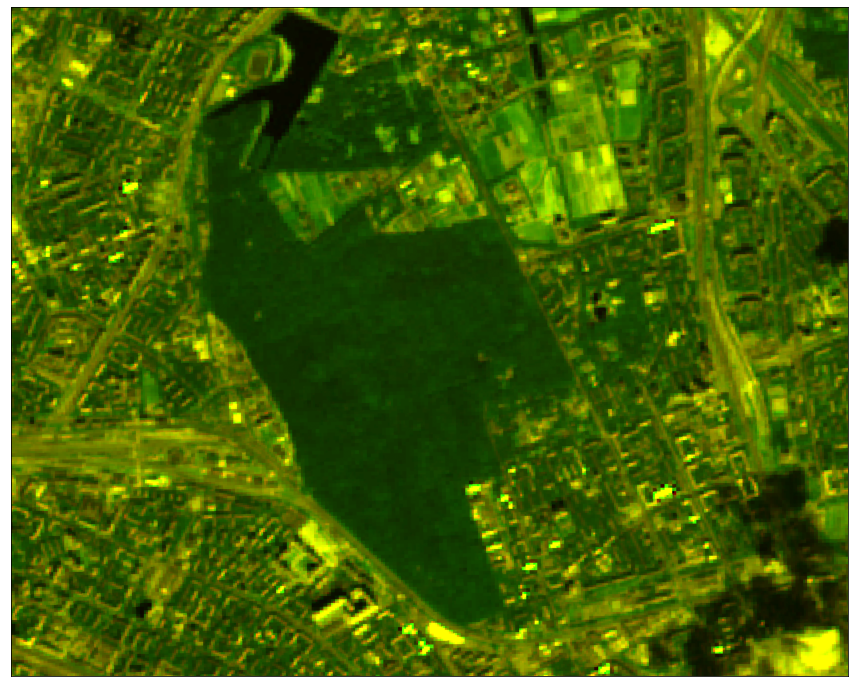

In [86]:
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, MimeType

# Write your credentials here if you haven't already put them into config.json
CLIENT_ID = ...
CLIENT_SECRET = ...

config = SHConfig()
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET


glacier_bbox = BBox([
    37.5165,
    55.8364,
    37.5849,
    55.8032
    ], crs=CRS.WGS84)
glacier_size = (2500, 2000)
time_interval = '2020-06-15', '2020-06-30'

evalscript_true_color = """
    function setup() {
        return {
            input: [{
                bands: ["B05", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B05];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=glacier_bbox,
    size=glacier_size,
    config=config
)

image = request.get_data()[0]


def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

plot_image(image, factor=3.5/255, clip_range=(0,1))